# Simple Audio Recognition for Voice Controlled Robot

In this tutorial we will show you how to build a basic speech recognition network that recognizes different words. It's important to know that real speech and audio recognition systems are much more complex, but it will give you a basic understanding of the techniques involved.

# Contents of This Note Book
* Importing Libraries and Data Set
* Checking Data Set with Different Operations
* Waveform to Spectogram Conversion
* Building and Training the Model
* Saving the Model
* Checking Model Accuracy
* TF Model to TF Lite Conversion
* TF Lite Interpreter
* TF Lite Model Prediction
* Comparison of TF & TF Lite Prediction

**Importing Libraries**

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

**Importing Speech Commands Data Set**

Here, we will be loading our drive for the data set of audio files in .wav format. There are 4 categories and each one consists of 20 files.

In [ ]:
# load the drive helper and mount
from google.colab import drive

# this will prompt for authorization.
drive.mount('/content/drive')

# after executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"

data_dir = pathlib.Path('/content/drive/MyDrive/voice robot')

**Check basic statistics about the dataset.**

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['right' 'left' 'go' 'stop']


**Extract the audio files into a list and shuffle it.**

In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

**Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.**

In [ ]:
train_files = filenames[:120]
val_files = filenames[120:135]
test_files = filenames[135:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 120
Validation set size 15
Test set size 15


### **Reading audio files and their labels**

The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.

To load an audio file, you will use [`tf.audio.decode_wav`](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav), which returns the WAV-encoded audio as a Tensor and the sample rate.

A WAV file contains time series data with a set number of samples per second. 
Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, like the files here, the values range from -32768 to 32767. 
The sample rate for this dataset is 16kHz.
Note that `tf.audio.decode_wav` will normalize the values to the range [-1.0, 1.0].

In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

The label for each WAV file is its parent directory.

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

You will now apply `process_path` to build your training set to extract the audio-label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

**Audio Waveforms with their corresponding Labels**

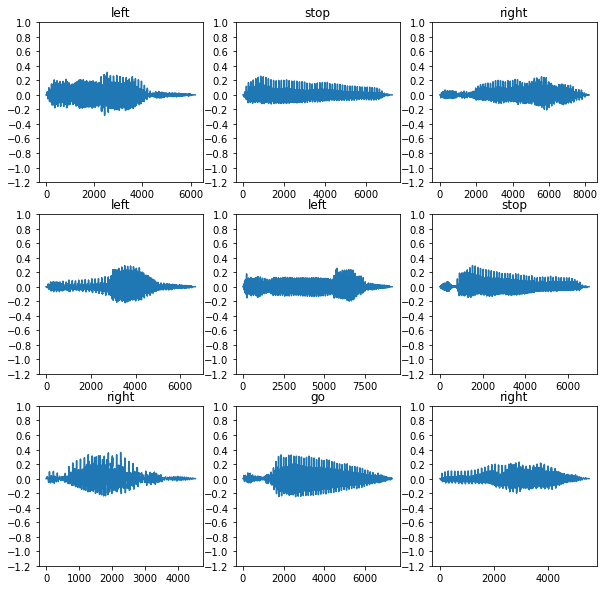

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

### **Spectrogram**

You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

A Fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but loses all time information. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`. 

Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square.

You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.


In [ ]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Examine the spectrogram "images" for different samples of the dataset.

### **Build and Train the model**

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training.

In [ ]:
batch_size = 1
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=5,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

**Training and Validation Loss**

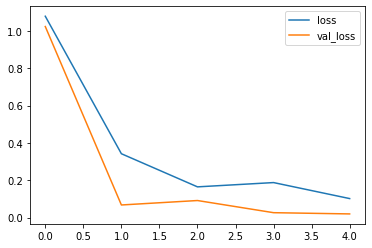

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

**Model Saving and Size Check**

In [ ]:
model.save ("model.h5")
print ('TF Size:', round(os.path.getsize("model.h5")/(1024*1024), 3) , 'MB')

TF Size: 18.646 MB


### **Test Set Accuracy Check**

Let's run the model on the test set and check performance.

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 100%


### **Model Prediction**

Finally, verify the model's prediction output using an input audio file. How well does your model perform?

In [ ]:
print (test_files)

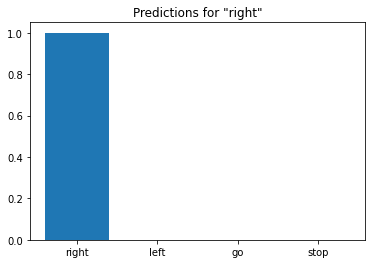

In [ ]:
# use any file here
# I'm printing test files names above to test those files here
sample_file = data_dir/'right/36.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

# **TF Lite Started**


**TF Model to TF Lite Conversion**

In [ ]:
# convert & optimize the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimization = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

**TF Lite Model Saving & Size Check**

In [ ]:
# save the model
open('tflite_model.tflite', 'wb').write(tflite_model)

# model size check
print ('TF Lite Size:', round(os.path.getsize('tflite_model.tflite')/(1024), 3) , 'KB')

TF Lite Size: 6351.02 KB


**Interpreter**

In [ ]:
# 'interpreter' to interpret tf lite model and to get input & output details
# models obtained from 'TfLiteConverter' can be run in python with 'interpreter'
interpreter = tf.lite.Interpreter('tflite_model.tflite')

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# print input & output values & shapes to check everything is same 
# as the orignal tf model.
# data types etc are changed during tf lite conversion & optimizations
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 124 129   1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 4]
Output Type: <class 'numpy.float32'>


**Comparison of TF & TF Lite Output**

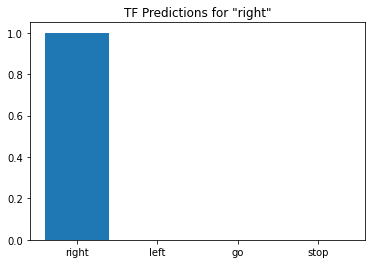

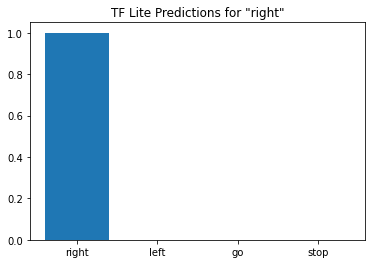

In [ ]:
sample_file = data_dir/'right/36.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'TF Predictions for "{commands[label[0]]}"')
  plt.show()

for spectrogram, label in sample_ds.batch(1):
  # needed before execution
  # tensorFlow lite pre-plans tensor allocations to optimize inference,
  # so the user needs to call allocate_tensors() before any inference.
  interpreter.allocate_tensors()
  interpreter.set_tensor(input_details[0]['index'],spectrogram)
  interpreter.invoke()

  # predicting from tf lite model
  predictionx = interpreter.get_tensor(output_details[0]['index'])
  plt.bar(commands, tf.nn.softmax(predictionx[0]))
  plt.title(f'TF Lite Predictions for "{commands[label[0]]}"')
  plt.show()
